In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Layer
from keras.layers import InputLayer, Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras.losses import categorical_crossentropy
from keras.metrics import top_k_categorical_accuracy
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
%matplotlib inline

Using TensorFlow backend.


In [2]:
BASE = 2304
MAX_DIM = 218
IMG_SHAPE = (32, 32)
BATCH = 32
EPOCHS = 75
CLASSES = 128

In [3]:
def show_image(img, name=''):
    plt.axis('off')
    plt.imshow(img)
    plt.title(name)

In [4]:
def load_data():
    images = []
    labels = []
    kernel = np.ones(shape=(3, 3), dtype=np.uint8)
    for f in glob.glob('q_train_images/*.png'):
        img = cv2.imread(f, 0)
        _, img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
        img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
        img = img.astype(np.float32) / 255
        images.append(img)
        lab = f.split('_')[5:]
        lab[-1] = lab[-1].split('.')[0]
        lab = list(map(int, lab))
        lab = [x - BASE for x in lab]
        labels.append(lab)
    return images, labels

In [5]:
images, labels = load_data()

In [6]:
def resize_images(images):
    resized_images = []
    for i in range(len(images)):
        img = images[i]
        height, width = img.shape
        pad_top_size = (MAX_DIM - img.shape[0]) // 2
        pad_bottom_size = MAX_DIM - pad_top_size - height
        pad_left_size = (MAX_DIM - img.shape[1]) // 2
        pad_right_size = MAX_DIM - pad_left_size - width
        pad_top = np.zeros(shape=(pad_top_size, img.shape[1]))
        pad_bottom = np.zeros(shape=(pad_bottom_size, img.shape[1]))
        img = np.vstack([pad_top, img, pad_bottom])
        pad_left = np.zeros(shape=(img.shape[0], pad_left_size))
        pad_right = np.zeros(shape=(img.shape[0], pad_right_size))
        img = np.hstack([pad_left, img, pad_right])
        img = cv2.resize(img, IMG_SHAPE)
        resized_images.append(img)
    return resized_images

In [7]:
images = resize_images(images)

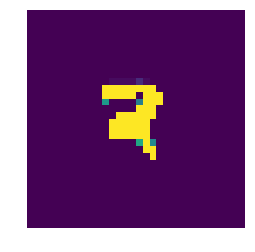

In [9]:
images = np.array(images)
show_image(images[2])

In [10]:
lab = np.zeros(shape=(images.shape[0], 128))
for i, lb in enumerate(labels):
    for j in lb:
        lab[i, j] = 1.

In [11]:
images = np.expand_dims(images, axis=3)

In [12]:
Xtr, Xval, ytr, yval = train_test_split(images, lab, test_size=0.1, 
                                        shuffle=True)

In [13]:
class Top5Round(Layer):
    
    def __init__(self, **kwargs):
        super(Top5Round, self).__init__(**kwargs)
    
    def get_output(self, train=False):
        X = self.get_input(train)
        sorted_idx = K.argsort(X)
        X[sorted_idx[-5:]] = K.round(X[sorted_idx[-5:]])
        X[sorted_idx[:-5]] = 0
        return X
    
    def get_config(self):
        config = {'name': self.__class__.__name__}
        base_config = super(Top5Round, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
model = Sequential()
model.add(InputLayer(input_shape=(IMG_SHAPE[0], IMG_SHAPE[1], 1)))

model.add(Conv2D(filters=32, 
                 kernel_size=5, 
                 padding='same', 
                 activation='relu'))
model.add(Conv2D(filters=32, 
                 kernel_size=5, 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,  
                 kernel_size=3, 
                 padding='same', 
                 activation='relu'))
model.add(Conv2D(filters=64, 
                 kernel_size=3, 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, 
                       strides=2))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64,  
                 kernel_size=3, 
                 padding='same', 
                 activation='relu'))
model.add(Conv2D(filters=64, 
                 kernel_size=3, 
                 padding='same', 
                 activation='relu'))
model.add(Conv2D(filters=64, 
                 kernel_size=3, 
                 padding='same', 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=2, 
                       strides=2))
model.add(Dropout(0.25))
          
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(CLASSES, activation='sigmoid'))
model.add(Top5Round())

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
__________

In [16]:
model.compile(loss=categorical_crossentropy, 
              optimizer=RMSprop(), 
              metrics=[top_k_categorical_accuracy])

In [17]:
train_datagen =  ImageDataGenerator(rotation_range=5, 
                                width_shift_range=0.1, 
                                height_shift_range=0.1, 
                                shear_range=0.1, 
                                zoom_range=0.2)

In [18]:
train_gen = train_datagen.flow(Xtr, ytr, batch_size=BATCH)

In [19]:
model.fit_generator(train_gen, 
                    steps_per_epoch=Xtr.shape[0]//BATCH,  
                    epochs=EPOCHS, 
                    verbose=1,  
                    validation_data=(Xval, yval))

Epoch 1/75
55/55 [==============================] - 30s - loss: 6.7523 - top_k_categorical_accuracy: 0.2227 - val_loss: 6.4146 - val_top_k_categorical_accuracy: 0.1980
Epoch 2/75
55/55 [==============================] - 34s - loss: 6.2647 - top_k_categorical_accuracy: 0.2185 - val_loss: 6.3611 - val_top_k_categorical_accuracy: 0.1980
Epoch 3/75
55/55 [==============================] - 33s - loss: 6.2044 - top_k_categorical_accuracy: 0.2074 - val_loss: 6.3204 - val_top_k_categorical_accuracy: 0.1523
Epoch 4/75
55/55 [==============================] - 35s - loss: 6.1643 - top_k_categorical_accuracy: 0.2106 - val_loss: 6.3083 - val_top_k_categorical_accuracy: 0.2081
Epoch 5/75
55/55 [==============================] - 35s - loss: 6.1122 - top_k_categorical_accuracy: 0.2140 - val_loss: 6.1734 - val_top_k_categorical_accuracy: 0.1827
Epoch 6/75
55/55 [==============================] - 31s - loss: 6.0209 - top_k_categorical_accuracy: 0.2310 - val_loss: 6.1181 - val_top_k_categorical_accuracy:

55/55 [==============================] - 27s - loss: 2.6452 - top_k_categorical_accuracy: 0.9071 - val_loss: 2.6759 - val_top_k_categorical_accuracy: 0.8934
Epoch 50/75
55/55 [==============================] - 25s - loss: 2.5425 - top_k_categorical_accuracy: 0.9000 - val_loss: 2.5967 - val_top_k_categorical_accuracy: 0.9137
Epoch 51/75
55/55 [==============================] - 26s - loss: 2.5097 - top_k_categorical_accuracy: 0.9142 - val_loss: 2.6876 - val_top_k_categorical_accuracy: 0.9036
Epoch 52/75
55/55 [==============================] - 26s - loss: 2.4842 - top_k_categorical_accuracy: 0.9153 - val_loss: 2.5926 - val_top_k_categorical_accuracy: 0.8985
Epoch 53/75
55/55 [==============================] - 26s - loss: 2.4834 - top_k_categorical_accuracy: 0.9133 - val_loss: 2.6117 - val_top_k_categorical_accuracy: 0.9137
Epoch 54/75
55/55 [==============================] - 25s - loss: 2.5221 - top_k_categorical_accuracy: 0.9119 - val_loss: 2.6886 - val_top_k_categorical_accuracy: 0.903

(array([42]),)

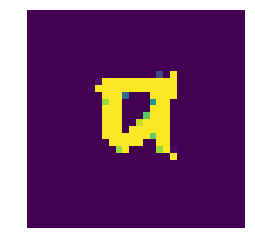

In [20]:
idx = np.random.randint(images.shape[0])
img = images[idx].reshape(IMG_SHAPE)
show_image(img)
np.where(lab[idx] == 1)

In [21]:
probs = model.predict(img.reshape(1, IMG_SHAPE[0], IMG_SHAPE[1], 1)).reshape(CLASSES)

In [22]:
top10probs = probs / np.max(probs)
top10 = np.argsort(top10probs)[-10:][::-1]
top10hex = [hex(BASE + x) for x in top10]
list(zip(top10, top10hex, top10probs[top10]))

[(42, '0x92a', 1.0),
 (55, '0x937', 0.00047328835),
 (77, '0x94d', 0.00033191813),
 (47, '0x92f', 0.00030351122),
 (48, '0x930', 3.2266398e-05),
 (46, '0x92e', 9.832178e-06),
 (2, '0x902', 6.3787656e-06),
 (62, '0x93e', 4.0711893e-06),
 (37, '0x925', 1.3802048e-06),
 (65, '0x941', 1.0445273e-06)]